# Install library

In [1]:
import os
import random

import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def set_randvalue(value):
    # Set a seed value
    seed_value= value 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)

set_randvalue(42)

## Dataset preprocessing and EDA

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() # load data
x_train,x_test = x_train.astype('float32')/255.0,x_test.astype('float32')/255.0 # normalization
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [5]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [6]:
# No method on keras to get cifar10 category label name by categoly label?
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

bird_ind = np.where(cifar10_labels=='bird')
deer_ind = np.where(cifar10_labels=='deer')
truck_ind = np.where(cifar10_labels=='truck')

In [7]:
remove_num = 2500
counter = 0
train_num = len(y_train) - remove_num * 3 # for 3 classes
x_train_removed =  np.zeros(x_train.shape)[:train_num]
y_train_removed =  np.zeros(y_train.shape)[:train_num]

# bird, deer, truck labeld data is removed by 2500
bird_limit, deer_limit, truck_limit = 0, 0, 0
for i, label in enumerate(y_train):
    if (label != bird_ind) & (label != deer_ind) & (label != truck_ind):
        x_train_removed[counter] = x_train[i]
        y_train_removed[counter] = y_train[i]
        counter += 1
    else:
        if label == bird_ind:
            if bird_limit < 2500:
                bird_limit += 1
                x_train_removed[counter] = x_train[i]
                y_train_removed[counter] = y_train[i]
                counter += 1
                continue
            else: continue
        if label == deer_ind:
            if deer_limit < 2500:
                deer_limit += 1
                x_train_removed[counter] = x_train[i]
                y_train_removed[counter] = y_train[i]
                counter += 1
                continue
            else: continue
        if label == truck_ind:
            if truck_limit < 2500:
                truck_limit += 1
                x_train_removed[counter] = x_train[i]
                y_train_removed[counter] = y_train[i]
                counter += 1
                continue
            else: continue

y_train_removed = np.array(y_train_removed, dtype='uint8')

In [8]:
print(x_train_removed.shape)
print(y_train_removed.shape)
del x_train
del y_train

(42500, 32, 32, 3)
(42500, 1)


In [9]:
df = pd.DataFrame(y_train_removed.flatten())
print(df.value_counts())
del df

0    5000
1    5000
3    5000
5    5000
6    5000
7    5000
8    5000
2    2500
4    2500
9    2500
dtype: int64


(array([5000., 5000., 2500., 5000., 2500., 5000., 5000., 5000., 5000.,
        2500.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

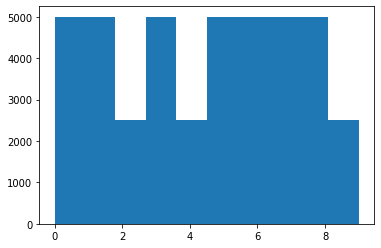

In [10]:
import matplotlib.pyplot as plt

# plot data labels
plt.hist(y_train_removed.flatten())

In [11]:
# train test split
# stratify y label
x_train_removed, x_valid_removed, y_train_removed, y_valid_removed = train_test_split(x_train_removed, y_train_removed, 
                                                                      test_size=0.3, random_state=42, stratify=y_train_removed)

In [12]:
print(x_train_removed.shape)
print(y_train_removed.shape)
print(x_valid_removed.shape)
print(y_valid_removed.shape)

(29750, 32, 32, 3)
(29750, 1)
(12750, 32, 32, 3)
(12750, 1)


In [13]:
df = pd.DataFrame(y_train_removed.flatten())
print(df.value_counts())
del df

0    3500
1    3500
3    3500
5    3500
6    3500
7    3500
8    3500
2    1750
4    1750
9    1750
dtype: int64


In [14]:
df = pd.DataFrame(y_valid_removed.flatten())
print(df.value_counts())
del df

0    1500
1    1500
3    1500
5    1500
6    1500
7    1500
8    1500
2     750
4     750
9     750
dtype: int64


## AutoEncoder

#### Load AE models weight

In [16]:
# Batch Norm Model
def create_AE01_model(k_size):
    input_img = Input(shape=(32, 32, 3))  # 0
    conv1 = Conv2D(64, (k_size, k_size), padding='same', name="Dense_AE01_1")(input_img) # 1
    conv1 = BatchNormalization(name="BN_AE01_1")(conv1) # 2
    conv1 = Activation('relu', name="Relu_AE01_1")(conv1) # 3
        
    decoded = Conv2D(3, (k_size, k_size), padding='same', name="Dense_AE01_2")(conv1) # 4
    decoded = BatchNormalization(name="BN_AE01_2")(decoded) # 5
    decoded = Activation('relu', name="Relu_AE01_2")(decoded) # 6
    return Model(input_img, decoded)

class AE01():
    def __init__(self, ksize, optimizer):
        self.optimizer = optimizer
        
        self.autoencoder = create_AE01_model(ksize)
        self.encoder = None

    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        self.autoencoder.compile(optimizer=self.optimizer, loss=loss)

    def train(self, x_train=None, x_test=None, epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
        ae_model_path = '../models/AE/AE01_AE_Best.hdf5'
        cp_cb = ModelCheckpoint(filepath = ae_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        history = self.autoencoder.fit(x_train, x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, x_test))
        
        self.autoencoder.load_weights(ae_model_path)
        
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)
        encode_model_path = '../models/AE/AE01_Encoder_Best.hdf5'
        self.encoder.save(encode_model_path)
        return history
    
    def load_weights(self, ae_model_path, encode_model_path):
        self.autoencoder.load_weights(ae_model_path)
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)
        self.encoder.load_weights(encode_model_path)

In [21]:
ae_ksize = 3
ae_optimizer = 'rmsprop'
stack01 = AE01(ae_ksize, ae_optimizer)
stack01.load_weights('../models/AE/AE01_AE_Best.hdf5', '../models/AE/AE01_Encoder_Best.hdf5')
stack01.encoder.trainable = False
stack01.encoder.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
Dense_AE01_1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
BN_AE01_1 (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
Relu_AE01_1 (Activation)     (None, 32, 32, 64)        0         
Total params: 2,048
Trainable params: 0
Non-trainable params: 2,048
_________________________________________________________________


## Train

#### Create Model AE to CNN

In [25]:
def create_StackedAE01_CNN01_model(encoder):
    input_img = encoder.input
    output = encoder.layers[-1].output # 32,32,64
    x = Conv2D(64,(3,3),padding = "same",activation= "relu")(output)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x) # 16,16,64
    
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x) # 8,8,128
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    y = Dense(10,activation = "softmax")(x)

    return Model(input_img, y)

model01 = create_StackedAE01_CNN01_model(stack01.encoder)
model01.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
Dense_AE01_1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
BN_AE01_1 (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
Relu_AE01_1 (Activation)     (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)      

#### Train without data augumentation 

In [26]:
%%time

adam = Adam() # defalut
model01.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

# one hot encoding
nb_classes = 10
y_train_removed_onehot = to_categorical(y_train_removed, nb_classes)
y_valid_removed_onehot = to_categorical(y_valid_removed, nb_classes)
y_test_onehot = to_categorical(y_test, nb_classes)

# train
saveDir = "../models/CNN/"

es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
chkpt = saveDir + 'Model_003_Best.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

model01_history = model01.fit(x_train_removed, y_train_removed_onehot,
                      batch_size=32,
                      epochs=400,
                      verbose=1,
                      validation_data=(x_valid_removed, y_valid_removed_onehot),
                      callbacks=[es_cb, cp_cb],
                      shuffle=True)

Epoch 1/400
930/930 [==============================] - ETA: 0s - loss: 1.3427 - accuracy: 0.5157
Epoch 00001: val_loss improved from inf to 1.34691, saving model to ../models/CNN\Model_003_Best.hdf5
930/930 [==============================] - 75s 81ms/step - loss: 1.3427 - accuracy: 0.5157 - val_loss: 1.3469 - val_accuracy: 0.5358
Epoch 2/400
930/930 [==============================] - ETA: 0s - loss: 0.9827 - accuracy: 0.6502
Epoch 00002: val_loss improved from 1.34691 to 0.99592, saving model to ../models/CNN\Model_003_Best.hdf5
930/930 [==============================] - 74s 80ms/step - loss: 0.9827 - accuracy: 0.6502 - val_loss: 0.9959 - val_accuracy: 0.6495
Epoch 3/400
930/930 [==============================] - ETA: 0s - loss: 0.8123 - accuracy: 0.7151
Epoch 00003: val_loss improved from 0.99592 to 0.93940, saving model to ../models/CNN\Model_003_Best.hdf5
930/930 [==============================] - 75s 81ms/step - loss: 0.8123 - accuracy: 0.7151 - val_loss: 0.9394 - val_accuracy: 0.6

Text(0.5, 0, 'epoch')

<Figure size 432x288 with 0 Axes>

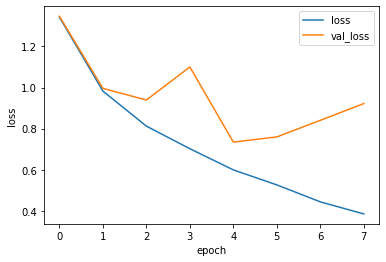

<Figure size 432x288 with 0 Axes>

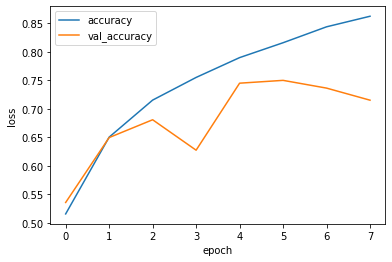

In [27]:
# plot training
mdoel01_hist_df = pd.DataFrame(model01_history.history)

plt.figure()
mdoel01_hist_df[['loss', 'val_loss']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

plt.figure()
mdoel01_hist_df[['accuracy', 'val_accuracy']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

In [28]:
model01.load_weights('../models/CNN/Model_003_Best.hdf5')
model01.evaluate(x_test, y_test_onehot)

313/313 [==============================] - 5s 15ms/step - loss: 0.8171 - accuracy: 0.7207


[0.8171173930168152, 0.7207000255584717]

#### Train with data augumentation

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/400
929/929 [==============================] - ETA: 0s - loss: 1.6738 - accuracy: 0.3895
Epoch 00001: val_loss improved from inf to 1.47538, saving model to ../models/CNN\Model_004_Best.hdf5
929/929 [==============================] - 73s 78ms/step - loss: 1.6738 - accuracy: 0.3895 - val_loss: 1.4754 - val_accuracy: 0.4702
Epoch 2/400
929/929 [==============================] - ETA: 0s - loss: 1.4304 - accuracy: 0.4845
Epoch 00002: val_loss improved from 1.47538 to 1.38607, saving model to ../models/CNN\Model_004_Best.hdf5
929/929 [==============================] - 72s 78ms/step - loss: 1.4304 - accuracy: 0.4845 - val_loss: 1.3861 - val_accuracy: 0.5128
Epoch 3/400
929/929 [==============================] - ETA: 0s - loss: 1.2972 - accuracy: 0.5336
Epoch 00003: val_loss did not improve from 1.38607
929/929 [==============================] - 73s 79ms/step - loss: 1.2972 - accuracy: 0.5336 - val_loss: 1.438

Text(0.5, 0, 'epoch')

<Figure size 432x288 with 0 Axes>

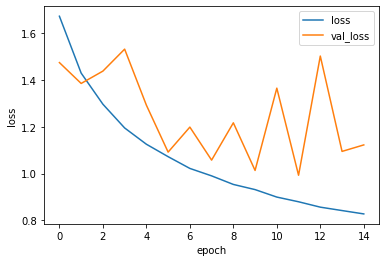

<Figure size 432x288 with 0 Axes>

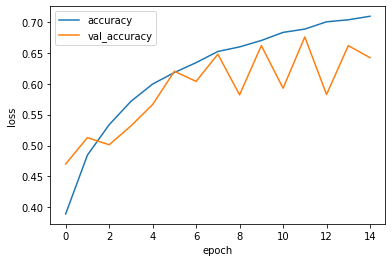

In [29]:
%%time

encoder = stack01.encoder
encoder.trainable = False
model02 = create_StackedAE01_CNN01_model(encoder) # transfer learning

adam = Adam() # defalut
model02.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

# one hot encoding
nb_classes = 10
y_train_removed_onehot = to_categorical(y_train_removed, nb_classes)
y_valid_removed_onehot = to_categorical(y_valid_removed, nb_classes)
y_test_onehot = to_categorical(y_test, nb_classes)

es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
chkpt = saveDir + 'Model_004_Best.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

train_datagen = ImageDataGenerator(
#     rescale=1./255,
    rotation_range=15,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    channel_shift_range=0.2
    )

batch_size = 32
train_datagenerator = train_datagen.flow(x_train_removed, y_train_removed_onehot, batch_size)
valid_datagenerator = ImageDataGenerator().flow(x_test, y_test_onehot, batch_size)

model02_history = model02.fit_generator(train_datagenerator,
                              steps_per_epoch=int(len(x_train_removed)//batch_size),
                              epochs=400,
                              validation_data=valid_datagenerator,
                              validation_steps=int(len(x_test)//batch_size),
                              verbose=1,
                              shuffle=True,
                              callbacks=[es_cb, cp_cb])

# plot training
mdoel02_hist_df = pd.DataFrame(model02_history.history)

plt.figure()
mdoel02_hist_df[['loss', 'val_loss']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

plt.figure()
mdoel02_hist_df[['accuracy', 'val_accuracy']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

In [30]:
model02.load_weights('../models/CNN/Model_004_Best.hdf5')
model02.evaluate(x_test, y_test_onehot)

313/313 [==============================] - 5s 16ms/step - loss: 0.9929 - accuracy: 0.6758


[0.9929497241973877, 0.6758000254631042]